In [96]:
"""
Full Pipeline: PubMedBERT Data Extraction Example

This script demonstrates:
  1. Loading PubMedBERT (a masked language model).
  2. Loading a local subset of PubMed data (papers.json).
  3. Generating candidate text with repeated fill-mask tokens.
  4. Applying a naive membership-inference-style filter
     using zlib compression ratio as a proxy for "unusually confident" text.
  5. Searching the local PubMed data to see if the text is indeed memorized
     (verbatim match).

DISCLAIMER:
  - PubMedBERT is not an auto-regressive model. Generating free-form
    text is tricky. We do a repeated fill-mask approach for demonstration.
  - The membership inference here is simplified. Real approaches might
    compare perplexities from multiple models or do more advanced metrics.
  - The substring search is naive and may need optimization or fuzzy matching.
  - This code is a proof-of-concept. Modify and expand to suit your needs.
"""
import os
import json
import re
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertForMaskedLM
from fuzzywuzzy import fuzz
from typing import List, Dict
import random
import spacy
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
nlp = spacy.load("en_core_sci_sm")

In [32]:
##########################################################################################
# CONFIGURATION
##########################################################################################
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
PUBMED_DATA = "../../Data/papersNew.json"  # PubMed abstracts in JSONL format
#PMC_DATA = "../../Data/pubmed_2010_2024_intelligence.json"         # PMC full-text in JSONL format
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Attack parameters
CONFIDENCE_THRESHOLD = 0.5  # Minimum confidence to flag predictions
NGRAM_SIZE = 3              # For fuzzy verification
FUZZY_THRESHOLD = 70        # Match threshold (0-100)

In [73]:
##########################################################################################
# DATA LOADING & PREPROCESSING
##########################################################################################
def load_pubmed_data(json_path: str) -> List[Dict]:
    """Load local PubMed abstracts from a JSON file."""
    if not os.path.exists(json_path):
        print(f"[ERROR] File not found: {json_path}")
        return []
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

##########################################################################################
# MASKED TOKEN GENERATION
##########################################################################################
def create_masked_examples(text, min_masks=4):
    """
    Create a masked example that masks:
      - Sensitive entities (via NER)
      - Tokens that look like numbers
      - Additional random words if fewer than min_masks tokens are masked
    Returns a list with one dictionary containing the original text,
    the masked text (with [MASK] tokens), a list of target tokens (original masked tokens),
    and a type label.
    """
    doc = nlp(text)
    mask_flags = [False] * len(doc)
    
    # Mark tokens as masked if they are part of a named entity (sensitive)
    for ent in doc.ents:
        for token in ent:
            mask_flags[token.i] = True
    
    # Mark tokens as masked if they are numbers
    for token in doc:
        if token.like_num:
            mask_flags[token.i] = True
    
    # Count current masked tokens
    current_mask_count = sum(mask_flags)
    
    # If the count is below the minimum threshold, randomly pick additional tokens (avoid punctuation)
    if current_mask_count < min_masks:
        candidates = [i for i, flag in enumerate(mask_flags) if not flag and not doc[i].is_punct]
        num_needed = min_masks - current_mask_count
        if candidates:
            extra_indices = random.sample(candidates, min(num_needed, len(candidates)))
            for idx in extra_indices:
                mask_flags[idx] = True
    
    # Build the masked text and record target tokens for evaluation
    masked_tokens = []
    target_tokens = []
    for i, token in enumerate(doc):
        if mask_flags[i]:
            masked_tokens.append("[MASK]")
            target_tokens.append(token.text)
        else:
            masked_tokens.append(token.text)
    
    masked_text = " ".join(masked_tokens)
    
    return [{
        "original": text,
        "masked": masked_text,
        "target": target_tokens,
        "type": "combined"
    }]

##########################################################################################
# PREDICTION & MEMORIZATION DETECTION
##########################################################################################
def predict_masked_tokens(model, tokenizer, masked_examples):
    """Predict masked tokens for examples with possibly multiple masks."""
    results = []
    for example in tqdm(masked_examples, desc="Predicting tokens"):
        inputs = tokenizer(
            example["masked"],
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(DEVICE)
        with torch.no_grad():
            logits = model(**inputs).logits

        mask_token_indices = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
        # If no mask tokens found (can happen if truncation removed them), skip example.
        if mask_token_indices.numel() == 0:
            continue

        predicted_token_ids = []
        confidences = []
        # Process each mask token individually.
        for idx in mask_token_indices:
            token_logits = logits[0, idx]
            probs = torch.softmax(token_logits, dim=0)
            confidence, token_id = torch.max(probs, dim=0)
            predicted_token_ids.append(token_id.item())
            confidences.append(confidence.item())

        # Decode tokens individually.
        predicted_tokens = [tokenizer.decode([tid]).strip() for tid in predicted_token_ids]

        results.append({
            "masked_text": example["masked"],
            "predicted_tokens": predicted_tokens,
            "confidences": confidences,
            "target_tokens": example["target"],
            "type": example["type"]
        })
    return results


def calculate_memorization_score(predictions):
    """
    Flag examples where all masked tokens match the target tokens 
    and each token's confidence exceeds the threshold.
    """
    memorized = []
    for pred in predictions:
        if len(pred.get("predicted_tokens", [])) != len(pred.get("target_tokens", [])):
            continue
        if all(pred_tok == target_tok for pred_tok, target_tok in zip(pred["predicted_tokens"], pred["target_tokens"])) and \
           all(conf > CONFIDENCE_THRESHOLD for conf in pred["confidences"]):
            memorized.append(pred)
    return memorized

##########################################################################################
# FUZZY VERIFICATION (CARLINI-STYLE)
##########################################################################################
def fuzzy_verify(memorized_candidates, training_data):
    """
    Check if a candidate's target token appears in the training data.
    This simple verification checks both PubMed abstracts and PMC full texts.
    """
    verified = []
    for candidate in memorized_candidates:
        # For each candidate, check each target token (assuming one candidate may have multiple tokens)
        all_verified = True
        for token in candidate["target_tokens"]:
            token_verified = False
            for entry in training_data:
                if "abstract" in entry and token in entry["abstract"].get("full_text", ""):
                    token_verified = True
                    break
                if "full_text" in entry and token in entry["full_text"]:
                    token_verified = True
                    break
            if not token_verified:
                all_verified = False
                break
        if all_verified:
            verified.append(candidate)
    return verified

In [34]:
# Load data and model
training_corpus = load_pubmed_data(PUBMED_DATA)

In [35]:
print("Loading PubMedBERT...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForMaskedLM.from_pretrained(MODEL_NAME).to(DEVICE)

Loading PubMedBERT...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# Generate masked examples
masked_examples = []
for entry in training_corpus:
    text = entry.get("abstract", {}).get("full_text", "")
    masked_examples.extend(create_masked_examples(text))

In [69]:
# Predict masked tokens
predictions = predict_masked_tokens(model, tokenizer, masked_examples)

Predicting tokens: 100%|██████████| 157833/157833 [56:47<00:00, 46.32it/s] 


In [72]:
 # Flag memorization candidates
memorized_candidates = calculate_memorization_score(predictions)
print(f"Flagged {len(memorized_candidates)} high-confidence candidates")

Flagged 24 high-confidence candidates


In [74]:
# Verify against training data
verified_memorized = fuzzy_verify(memorized_candidates, training_corpus)
print(f"Verified {len(verified_memorized)} memorized tokens")

# Save results
with open("pubmedbert_memorization_extra_results.json", "w") as f:
    json.dump(verified_memorized, f, indent=2)

Verified 24 memorized tokens


In [78]:

def calculate_hit_masks(predictions):
    """
    Return a list of individual hit masks where each masked token is predicted correctly
    with a confidence above the threshold.
    """
    hits = []
    for pred in predictions:
        predicted_tokens = pred.get("predicted_tokens", [])
        target_tokens = pred.get("target_tokens", [])
        confidences = pred.get("confidences", [])
        for idx, (predicted, target, conf) in enumerate(zip(predicted_tokens, target_tokens, confidences)):
            if predicted == target and conf > CONFIDENCE_THRESHOLD:
                hits.append({
                    "predicted_token": predicted,
                    "target_token": target,
                    "confidence": conf,
                    "type": pred.get("type", "unknown")
                })
    return hits

In [79]:
hit_masks = calculate_hit_masks(predictions)
print(f"Hit masks: {len(hit_masks)}")

Hit masks: 145386


In [80]:
hit_masks

[{'predicted_token': 'emphasis',
  'target_token': 'emphasis',
  'confidence': 0.6635357737541199,
  'type': 'combined'},
 {'predicted_token': 'ontology',
  'target_token': 'ontology',
  'confidence': 0.7040163278579712,
  'type': 'combined'},
 {'predicted_token': 'effect',
  'target_token': 'effect',
  'confidence': 0.5235113501548767,
  'type': 'combined'},
 {'predicted_token': 'evidence',
  'target_token': 'evidence',
  'confidence': 0.8234941363334656,
  'type': 'combined'},
 {'predicted_token': 'former',
  'target_token': 'former',
  'confidence': 0.8035507202148438,
  'type': 'combined'},
 {'predicted_token': 'one',
  'target_token': 'one',
  'confidence': 0.8124209642410278,
  'type': 'combined'},
 {'predicted_token': 'level',
  'target_token': 'level',
  'confidence': 0.633175790309906,
  'type': 'combined'},
 {'predicted_token': 'late',
  'target_token': 'late',
  'confidence': 0.8428701758384705,
  'type': 'combined'},
 {'predicted_token': 'positive',
  'target_token': 'posit

In [89]:
len(hit_masks)

145386

In [94]:
def visualize_results(predictions, hit_masks, verified_memorized):
    """
    Visualize results:
    1. Plot the count of hit masks out of the total masked tokens predicted.
    2. Plot the top 5 repeating correctly predicted (hit) tokens with their frequency.
    """
    # Compute total number of masked tokens predicted across all examples.
    total_masks = sum(len(pred.get("predicted_tokens", [])) for pred in predictions)
    hit_count = len(hit_masks)
    
    # Plot a pie chart: hit masks vs missed masks.
    labels = [f'Hit Masks - {hit_count}', f'Missed Masks - {total_masks - hit_count}']
    sizes = [hit_count, total_masks - hit_count]
    plt.figure()
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis("equal")
    plt.show()
    
    # Compute frequency distribution for hit masks (correctly predicted tokens).
    hit_token_freq = {}
    for hm in hit_masks:
        token = hm["predicted_token"]
        hit_token_freq[token] = hit_token_freq.get(token, 0) + 1

    # Compute frequency distribution for target tokens across all predictions.
    target_token_freq = {}
    for pred in predictions:
        for token in pred.get("target_tokens", []):
            target_token_freq[token] = target_token_freq.get(token, 0) + 1

    # Get the top 5 tokens by hit frequency.
    top_tokens = sorted(hit_token_freq.items(), key=lambda x: x[1], reverse=True)[:5]
    tokens, hit_frequencies = zip(*top_tokens) if top_tokens else ([], [])

    # For each top token, get its total count in the target and compute the missed count.
    target_counts = [target_token_freq.get(token, 0) for token in tokens]
    missed_counts = [total - hit for total, hit in zip(target_counts, hit_frequencies)]
    
    # Plot grouped bar chart for top 5 tokens: hits and misses.
    x = np.arange(len(tokens))
    width = 0.35  # width of the bars

    plt.figure()
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, hit_frequencies, width, label='Hit')
    rects2 = ax.bar(x + width/2, missed_counts, width, label='Missed')
    
    # Add labels, title, and custom x-axis tick labels.
    ax.set_ylabel('Count')
    ax.set_title('Top 5 Hit Tokens: Hit vs Missed Counts')
    ax.set_xticks(x)
    ax.set_xticklabels(tokens)
    ax.legend()
    
    # Add text labels on top of the bars.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()

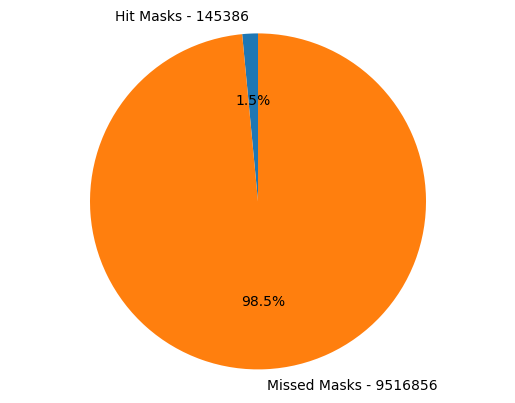

<Figure size 640x480 with 0 Axes>

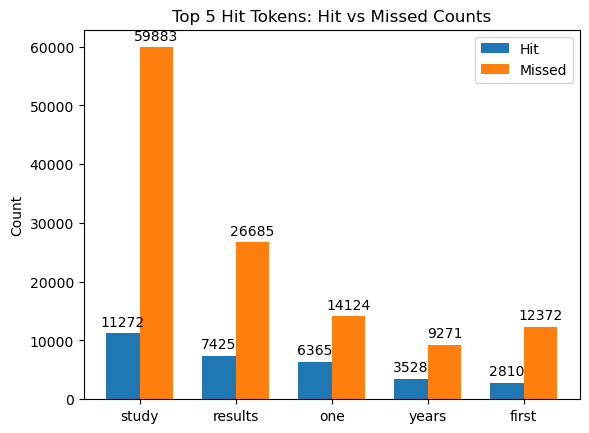

In [97]:
visualize_results(predictions, hit_masks, verified_memorized)